In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import math

In [3]:
from src.utils import haversine, calc_xydist
from src.quadtree import Point, Rect, QuadTree

In [4]:
deg_offset = 0.05 # about 5 km, used to expand the coverage area slightly

In [5]:
train_path = 'data/train.csv'

In [6]:
train = pd.read_csv(train_path)

In [7]:
train.shape

(431732, 17)

In [8]:
train.describe()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,resale_price
count,431732.000000,431732.000000,431732.000000,431732.000000,431732.0,4.317320e+05
mean,96.970064,1989.421004,1.364939,103.836492,0.0,3.018196e+05
std,25.190664,10.254055,0.042829,0.073527,0.0,1.298623e+05
min,31.000000,1966.000000,1.270380,103.685228,0.0,2.970000e+04
25%,74.000000,1983.000000,1.336154,103.772439,0.0,2.052000e+05
50%,99.000000,1988.000000,1.358958,103.840160,0.0,2.839500e+05
75%,114.000000,1997.000000,1.389004,103.895779,0.0,3.735000e+05
max,280.000000,2019.000000,1.457071,103.987805,0.0,1.123200e+06


# Calculate SW and NE corner points to denote bounding area 

In [9]:
ref_min_lat = train['latitude'].min() - deg_offset
ref_min_long = train['longitude'].min() - deg_offset
ref_max_lat = train['latitude'].max() + deg_offset
ref_max_long = train['longitude'].max() + deg_offset

print(f"Reference Origin (lat, long): {ref_min_lat}, {ref_min_long}")
print(f"Maximum Coord (lat, long): {ref_max_lat}, {ref_max_long}")

Reference Origin (lat, long): 1.2203795117581597, 103.63522841782499
Maximum Coord (lat, long): 1.5070712161383, 104.037804503483


In [10]:
# 1st entry in data
train.iloc[0]
# manually validate coord in google maps

month                            2001-08
town                           pasir ris
flat_type                         4 room
block                                440
street_name            pasir ris drive 4
storey_range                    01 to 03
floor_area_sqm                       118
flat_model                       model a
eco_category               uncategorized
lease_commence_date                 1989
latitude                         1.36901
longitude                        103.959
elevation                              0
subzone                  pasir ris drive
planning_area                  pasir ris
region                       east region
resale_price                      209700
Name: 0, dtype: object

In [11]:
test_lat, test_long = train.iloc[0][['latitude','longitude']]

In [12]:
test_x, test_y = calc_xydist(test_long, test_lat, ref_min_long,ref_min_lat)
print(f"Distance to origin (x,y): {test_x},{test_y} km")

Distance to origin (x,y): 35.95775442315713,16.5267442089845 km


In [13]:
dist = haversine(test_long, test_lat, ref_min_long,ref_min_lat)
print(f"Euclid distance to origin: {dist} km")

Euclid distance to origin: 39.57487375074682 km


Above distance checked against visual inspection on Google Maps

# Quadtree data structure and radius search

In [14]:
width, height = calc_xydist(ref_max_long, ref_max_lat, ref_min_long,ref_min_lat)
width = math.ceil(width)
height = math.ceil(height)
print(width, height) # Bounding box size in km

45 32


In [15]:
mrt_data_path = 'data/auxiliary-data/sg-train-stations.csv'

In [16]:
mrt = pd.read_csv(mrt_data_path)

In [17]:
mrt.head()

,name,codes,lat,lng,opening_year,type
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt


In [18]:
mrt['x'] = np.nan
mrt['y'] = np.nan
mrt['long_name'] = mrt['name'] + '_' + mrt['type']

mrt.head()

,name,codes,lat,lng,opening_year,type,x,y,long_name
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt,NaN,NaN,Eunos_mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt,NaN,NaN,Chinese Garden_mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt,NaN,NaN,Khatib_mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt,NaN,NaN,Kranji_mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt,NaN,NaN,Redhill_mrt


In [19]:
def create_qtree(df, name_col = 'name'):
    qtree = QuadTree(domain, 3)
    points = []
    for index, row in df.iterrows():
        x, y = calc_xydist(row.lng, row.lat, ref_min_long,ref_min_lat)

        df['x'][index] = round(x, 2)
        df['y'][index] = round(y, 2)

        point = Point(x, y, name=row[name_col])

        points.append(point)
        qtree.insert(point)
        
    return qtree, points

In [20]:
def plot_qtree(points, qtree):
    print(len(qtree))
    print(len(points))
    DPI = 72
    fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
    ax = plt.subplot()
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    qtree.draw(ax)
    ax.scatter([p.x for p in points], [p.y for p in points], s=4)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

## MRT Info

In [21]:
# TODO: Better way?
domain = Rect(width/2, height/2, width, height)

mrt_qtree, mrt_points = create_qtree(mrt, name_col='long_name')
mrt.head()

C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,codes,lat,lng,opening_year,type,x,y,long_name
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt,29.79,11.05,Eunos_mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt,10.82,13.56,Chinese Garden_mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt,21.98,21.91,Khatib_mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt,14.11,22.77,Kranji_mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt,20.19,7.69,Redhill_mrt


166
166


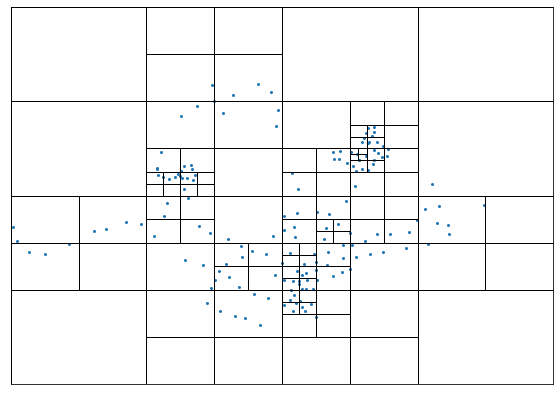

In [22]:
plot_qtree(mrt_points, mrt_qtree)

Number of found points = 25
Oasis_other
Sam Kee_other
Farmway_other
Kadaloor_other
Coral Edge_other
Riviera_mrt
Cove_other
Kangkar_other
Meridian_other
Ranggung_other
Bakau_other
Rumbia_other
Cheng Lim_other
Compassvale_other
Sengkang_mrt
Sengkang_mrt
Punggol_mrt
Samudera_other
Nibong_other
Soo Teck_other
Damai_other
Punggol Point_other
Sumang_other
Punggol_mrt
Teck Lee_other


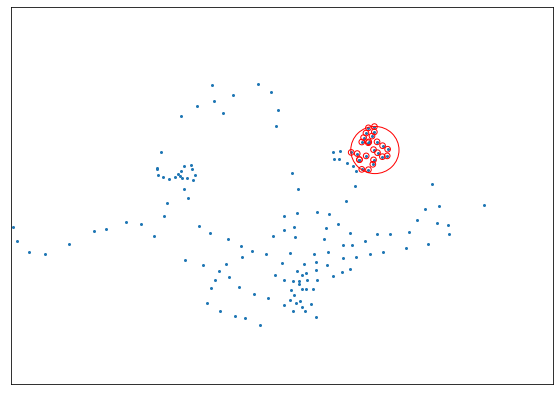

In [23]:
# Query point
(test_x,test_y) = (30.21,19.86)
centre = (test_x,test_y)
radius = 2 # in km 
found_points = []
mrt_qtree.query_radius((test_x,test_y), radius, found_points)


print('Number of found points =', len(found_points))
for p in found_points:
    print(p.name)

# Plot results
DPI = 72
fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
ax = plt.subplot()

ax.set_xlim(0, width)
ax.set_ylim(0, height)

# Plot all points
ax.scatter([p.x for p in mrt_points], [p.y for p in mrt_points], s=4)
ax.set_xticks([])
ax.set_yticks([])

# Plot found points
ax.scatter([p.x for p in found_points], [p.y for p in found_points],
           facecolors='none', edgecolors='r', s=32)

# Draw search radius
circle = plt.Circle(centre, radius, ec='r', fill=False)
ax.add_patch(circle)
# Rect(*centre, 2*radius, 2*radius).draw(ax, c='r')

plt.show()

In [24]:
train.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,resale_price
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,1.369008,103.958697,0.0,pasir ris drive,pasir ris,east region,209700.0
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,1.399007,103.906991,0.0,punggol field,punggol,north-east region,402300.0
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,1.388348,103.873815,0.0,fernvale,sengkang,north-east region,351000.0
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,1.318493,103.766702,0.0,clementi north,clementi,west region,151200.0
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,1.348149,103.742658,0.0,bukit batok west,bukit batok,west region,318600.0


## Primary Schools

In [25]:
prisch_data_path = 'data/auxiliary-data/sg-primary-schools.csv'
prisch = pd.read_csv(prisch_data_path)

prisch['x'] = np.nan
prisch['y'] = np.nan

prisch_qtree, prisch_points = create_qtree(prisch)

prisch.head()


C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,lat,lng,x,y
0,Admiralty Primary School,1.442941,103.800345,18.35,24.75
1,Ahmad Ibrahim Primary School,1.433849,103.832710,21.95,23.74
2,Ai Tong School,1.360713,103.833018,21.99,15.60
3,Alexandra Primary School,1.291284,103.824066,20.99,7.88
4,Anchor Green Primary School,1.390380,103.887354,28.03,18.90


191
191


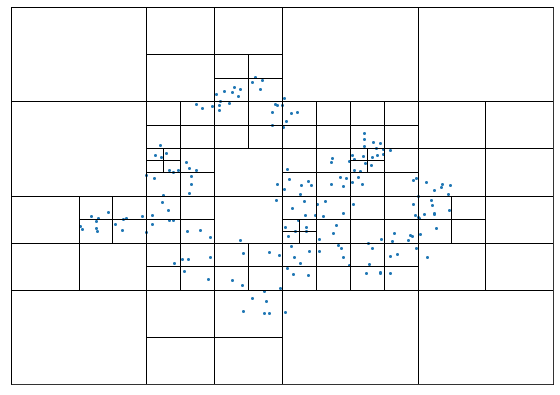

In [26]:
plot_qtree(prisch_points, prisch_qtree)

## Secondary Schools

In [27]:
secsch_data_path = 'data/auxiliary-data/sg-secondary-schools.csv'
secsch = pd.read_csv(secsch_data_path)
secsch['x'] = np.nan
secsch['y'] = np.nan

secsch_qtree, secsch_points = create_qtree(secsch)


C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


150
150


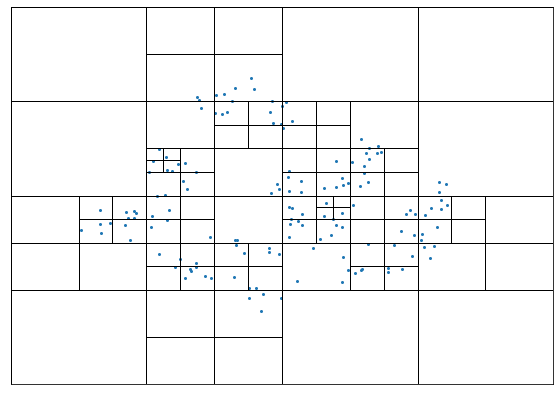

In [28]:
plot_qtree(secsch_points, secsch_qtree)

## Markets and Hawker Centers

In [29]:
markets_data_path = 'data/auxiliary-data/sg-gov-markets-hawker-centres.csv'
markets = pd.read_csv(markets_data_path)
markets['x'] = np.nan
markets['y'] = np.nan

markets_qtree, markets_points = create_qtree(markets)

C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


114
114


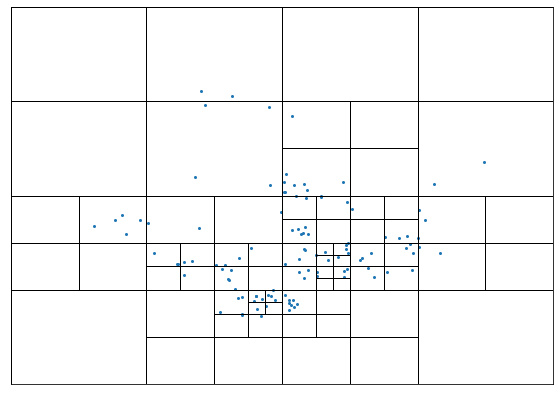

In [30]:
plot_qtree(markets_points, markets_qtree)

## Shopping Malls

In [31]:
malls_data_path = 'data/auxiliary-data/sg-shopping-malls.csv'
malls = pd.read_csv(malls_data_path)
malls['x'] = np.nan
malls['y'] = np.nan

malls_qtree, malls_points = create_qtree(malls)

C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


174
174


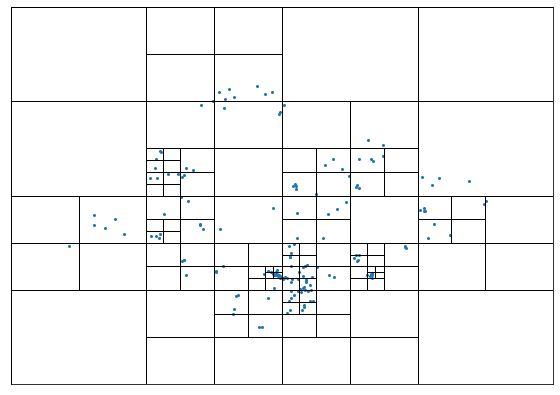

In [32]:
plot_qtree(malls_points, malls_qtree)

## Commercial Centers

In [33]:
comm_data_path = 'data/auxiliary-data/sg-commerical-centres.csv'
comm = pd.read_csv(comm_data_path)

comm['x'] = np.nan
comm['y'] = np.nan
comm['long_name'] = comm['name'] + '_' + comm['type']
comm_qtree, comm_points = create_qtree(comm, name_col='long_name')

C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


38
38


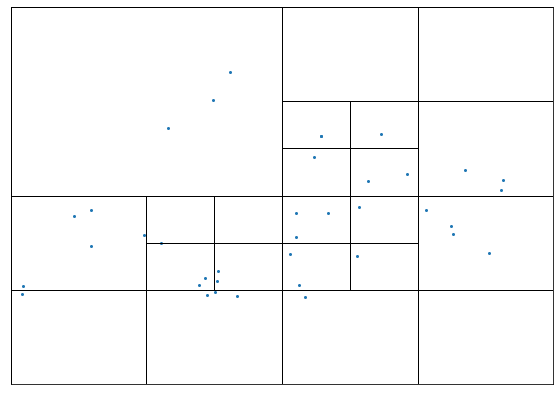

In [34]:
plot_qtree(comm_points, comm_qtree)

In [35]:
def find_features(qtree, x, y, radius = 3):
    # Count features in 2km, 1km radius, + nearest distance
    # radius = 3
    found_points = []
    qtree.query_radius((x, y), radius, found_points)
    
    count_2km = 0
    count_1km = 0
    nearest_dist = 999
    
    if found_points:
        for p in found_points:
            tmp_dist = round(Point(x,y).distance_to(p),2)
            if tmp_dist <= 2.0:
                count_2km += 1
            if tmp_dist <= 1.0:
                count_1km += 1
            if tmp_dist < nearest_dist:
                nearest_dist = tmp_dist
    return count_2km, count_1km, nearest_dist

In [36]:
import math
batches = 10
rows = train.shape[0]
delta = math.ceil(rows/batches)
batch_indexes = []
for i in range(batches):
    batch_indexes.append(i*delta)
    
batch_indexes.append(rows)
print(batch_indexes)   
print(len(batch_indexes))

[0, 43174, 86348, 129522, 172696, 215870, 259044, 302218, 345392, 388566, 431732]
11


In [41]:
from tqdm import tqdm

In [42]:
%%time

import time

train = pd.read_csv(train_path)
train['x'] = np.nan
train['y'] = np.nan

# The value in dict is the search radius. should be larger for comm due to low quantity
amenities = {'mrt':2, 'prisch':2, 'secsch':2, 'markets':4, 'malls':3, 'comm':10}

for amenity in amenities:
    train[amenity + '_2km'] = 0
    train[amenity + '_1km'] = 0
    train[amenity + '_ndist'] = None    

start_time = time.time()
for i in range(len(batch_indexes)):
    
    print(f"Processing:{batch_indexes[i]} - {batch_indexes[i+1]}")
    
    for idx, row in tqdm(train[batch_indexes[i]:batch_indexes[i+1]].iterrows()):
        index  = idx + batch_indexes[i]
        
        x, y = calc_xydist(row.longitude, row.latitude, ref_min_long,ref_min_lat)
        x = round(x, 2)
        y = round(y, 2)

        train['x'][index] = x
        train['y'][index] = y

        # Iterate over amenities
        for amenity in amenities:
            a, b, c = find_features(eval(amenity+'_qtree'), x, y, amenities[amenity])
            train[amenity + '_2km'][index] = a
            train[amenity + '_1km'][index] = b
            train[amenity + '_ndist'][index] = c
            
    print("--- %.2f seconds ---" % (time.time() - start_time))

0it [00:00, ?it/s]

Processing:0 - 43174


C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\dpramr\AppData\Roaming\Python\Pyth

--- 798.63 seconds ---
Processing:43174 - 86348


43174it [14:40, 49.03it/s]
3it [00:00, 26.75it/s]

--- 1679.12 seconds ---
Processing:86348 - 129522


43174it [16:33, 43.45it/s]
2it [00:00, 19.99it/s]

--- 2672.82 seconds ---
Processing:129522 - 172696


43174it [18:24, 39.10it/s]
3it [00:00, 24.99it/s]

--- 3776.99 seconds ---
Processing:172696 - 215870


43174it [18:09, 39.63it/s]
0it [00:00, ?it/s]

--- 4866.52 seconds ---
Processing:215870 - 259044


43174it [2:03:52,  5.81it/s]
0it [00:00, ?it/s]

--- 12298.53 seconds ---
Processing:259044 - 302218


20005it [55:56,  5.96it/s]


KeyboardInterrupt: 

In [77]:
not_processed_df = train[train['prisch_ndist'].isnull()]

In [78]:
processed_df = train[train['prisch_ndist'].notnull()]

In [79]:
not_processed_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,secsch_ndist,markets_2km,markets_1km,markets_ndist,malls_2km,malls_1km,malls_ndist,comm_2km,comm_1km,comm_ndist
43174,2008-03,jurong west,3 room,485,Jurong West Avenue 1,07 to 09,73.0,model a,uncategorized,1984,...,None,0,0,None,0,0,None,0,0,None
43175,2002-04,jurong west,executive,912,jurong west street 91,04 to 06,146.0,apartment,uncategorized,1988,...,None,0,0,None,0,0,None,0,0,None
43176,2019-10,geylang,4 room,349,ubi avenue 1,04 to 06,104.0,model a,uncategorized,1986,...,None,0,0,None,0,0,None,0,0,None
43177,2004-06,woodlands,5 room,787B,woodlands crescent,01 to 03,122.0,improved,uncategorized,1997,...,None,0,0,None,0,0,None,0,0,None
43178,2001-02,choa chu kang,executive,558,choa chu kang north 6,10 to 12,146.0,apartment,uncategorized,1996,...,None,0,0,None,0,0,None,0,0,None


In [80]:
processed_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,secsch_ndist,markets_2km,markets_1km,markets_ndist,malls_2km,malls_1km,malls_ndist,comm_2km,comm_1km,comm_ndist
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,...,0.42,1,1,0.95,2,0,1.03,0,0,2.32
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,...,0.31,0,0,3.78,6,4,0.8,1,0,1.46
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,...,0.56,1,0,1.81,4,2,0.45,1,0,1.44
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,...,0.62,5,2,0.62,4,3,0.46,0,0,2.39
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,...,0.22,2,1,0.76,5,1,0.77,1,0,1.81


In [83]:
col_to_drop = ['x','y']
for amenity in amenities:
    col_to_drop.append(amenity + '_2km')
    col_to_drop.append(amenity + '_1km')
    col_to_drop.append(amenity + '_ndist')
    
print(col_to_drop)

['x', 'y', 'mrt_2km', 'mrt_1km', 'mrt_ndist', 'prisch_2km', 'prisch_1km', 'prisch_ndist', 'secsch_2km', 'secsch_1km', 'secsch_ndist', 'markets_2km', 'markets_1km', 'markets_ndist', 'malls_2km', 'malls_1km', 'malls_ndist', 'comm_2km', 'comm_1km', 'comm_ndist']


In [85]:
not_processed_df = not_processed_df.drop(col_to_drop, axis=1)

In [86]:
not_processed_df.to_csv('data/not_processed.csv', index=False)

In [87]:
processed_df.to_csv('data/processed.csv', index=False)

In [55]:
import multiprocessing

# create as many processes as there are CPUs on your machine
num_processes = multiprocessing.cpu_count()
print(num_processes)
# calculate the chunk size as an integer
chunk_size = int(train.shape[0]/num_processes)

# this solution was reworked from the above link.
# will work even if the length of the dataframe is not evenly divisible by num_processes
chunks = [train.iloc[train.index[i:i + chunk_size]] for i in range(0, train.shape[0], chunk_size)]

12


In [60]:
chunks[0].shape

(35977, 37)

In [61]:
def myfunc(d):
    for index, row in d.iterrows():
            
        x, y = calc_xydist(row.longitude, row.latitude, ref_min_long,ref_min_lat)
        x = round(x, 2)
        y = round(y, 2)

        d['x'][index] = x
        d['y'][index] = y

        # Iterate over amenities
        for amenity in amenities:
            a, b, c = find_features(eval(amenity+'_qtree'), x, y, amenities[amenity])
            d[amenity + '_2km'][index] = a
            d[amenity + '_1km'][index] = b
            d[amenity + '_ndist'][index] = c   
    
    return d

In [ ]:
import src.defs
# create our pool with `num_processes` processes
pool = multiprocessing.Pool(processes=num_processes)

# apply our function to each chunk in the list
result = pool.map(src.defs.myfunc, chunks)